This is the notebook associated with the blog post titled Interactive Explainable Machine Learning with SAS Viya, Streamlit and Docker

Install SWAT if you haven't done so already. Import the required modules

In [ ]:
#!pip install swat
from swat import CAS, options
import pandas as pd
import numpy as np

Connect to CAS and load the required action sets

In [2]:
host = ""
port = ""
username = ""
password = ""

In [3]:
s = CAS(host, port, username, password)
s.loadActionSet('autotune')
s.loadactionset('aStore')
s.loadactionset('decisionTree')
s.loadactionset("explainModel")
s.loadactionset('table')

NOTE: Added action set 'autotune'.
NOTE: Added action set 'aStore'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'explainModel'.
NOTE: Added action set 'table'.


[actionset]

 'table'

+ Elapsed: 0.000442s, user: 0.000386s, mem: 0.221mb

Load and inspect the dataset

In [4]:
hmeq = pd.read_csv('hmeq.csv')
hmeq

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Load the dataframe to a CASTable and train a model and perform hyperparameter optimization

In [5]:
s.upload(hmeq,casout={'name' : 'hmeqTest', 'caslib' : 'public','replace' : True})

result = s.autotune.tuneGradientBoostTree(
    trainOptions = {
        "table"   : {"name":'hmeqTest', 'caslib' : 'public'},
        "inputs"  : {'LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC','REASON', 'JOB'},
        "target"  : 'BAD',
        "nominal" : {'BAD','REASON', 'JOB'},
        "casout"  : {"name":"gradboosthmeqtest", "caslib":"public",'replace':True},
        "varImp" : True
    },
    tunerOptions={"seed":12345, "maxTime":60}
)

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQTEST in caslib public.
NOTE: The table HMEQTEST has been created in caslib public from binary data uploaded to Cloud Analytic Services.
NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXTIME=60 (sec.).
NOTE: Autotune option SEED=12345.
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             8.7248          0.74
                 1          25              7.047         16.95
                 2          47              7.047         37.59
                 3          64           

Promote the table with training data, export the astore and promote the astore to global scope. Important for the Streamlit portion

In [6]:
s.table.promote(name="hmeqTest", caslib='public',target="hmeqTest",targetLib='public')
modelAstore = s.decisionTree.dtreeExportModel(modelTable = {"caslib":"public","name":"gradboosthmeqtest" }, 
                                        casOut = {"caslib":"public","name":'hmeqTestAstore','replace':True})

s.table.promote(name='hmeqTestAstore', caslib='public',target='hmeqTestAstore',targetLib='public')

NOTE: Cloud Analytic Services promoted table HMEQTEST in caslib Public to table hmeqTest in caslib public.
NOTE: 2916531 bytes were written to the table "hmeqTestAstore" in the caslib "public".
NOTE: Cloud Analytic Services promoted table HMEQTESTASTORE in caslib Public to table hmeqTestAstore in caslib public.


+ Elapsed: 0.00629s, user: 0.00114s, sys: 0.00478s, mem: 0.315mb

Let's test out the model. Create a sample observation, convert it to a pandas dataframe, then a cas table and score against the model

In [24]:
#Convert dictonary of input data to pandas dataframe (a tabular data format for scoring)
datadict = {'BAD':0,'LOAN':140,'MORTDUE':3000, 'VALUE':40000, 'REASON':'HomeImp','JOB':'Other','YOJ':12,
           'DEROG':0.0,'DELINQ':0.0, 'CLAGE':89,'NINQ':1.0, 'CLNO':10.0, 'DEBTINC':0.05} 

In [25]:
sample = pd.Series(datadict).to_frame().T

score this against the model

In [26]:
s.upload(samplepd,casout={'name' : 'realtime', 'caslib' : 'public','replace' : True})
s.aStore.score(rstore = {"caslib":"public","name":"hmeqTestAstore"},
                    table = {"caslib":'public',"name":'realtime'},
                    out = {"caslib":'public',"name":'realscore', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table REALTIME in caslib public.
NOTE: The table REALTIME has been created in caslib public from binary data uploaded to Cloud Analytic Services.


[OutputCasTables]

    casLib       Name  Rows  Columns                                casTable
 0  Public  realscore     1        4  CASTable('realscore', caslib='Public')

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000105  0.000913
 1  Creating the State  0.111629  0.971795
 2             Scoring  0.002851  0.024820
 3               Total  0.114869  1.000000

+ Elapsed: 0.118s, user: 0.113s, mem: 32.6mb

Inspect the scores

In [27]:
scoredData = s.CASTable(name='realscore',caslib='public')
datasetDict = scoredData.to_dict()
scores = pd.DataFrame(datasetDict, index=[0])
scores

,P_BAD1,P_BAD0,I_BAD,_WARN_
0,0.705085,0.294915,1,


Convert this to a neat little function for later use in the app

In [28]:
def score(samplepd):
    s.upload(samplepd,casout={'name' : 'realtime', 'caslib' : 'public','replace' : True})
    s.aStore.score(rstore = {"caslib":"public","name":"hmeqTestAstore"},
                        table = {"caslib":'public',"name":'realtime'},
                        out = {"caslib":'public',"name":'realscore', 'replace':True})
    #scoretable2= s.table.fetch(score_tableName)
    scoredData = s.CASTable(name='realscore',caslib='public')
    datasetDict = scoredData.to_dict()
    scores = pd.DataFrame(datasetDict, index=[0])
    return scores
    

Test to make sure this works

In [29]:
score(samplepd)

NOTE: Cloud Analytic Services made the uploaded file available as table REALTIME in caslib public.
NOTE: The table REALTIME has been created in caslib public from binary data uploaded to Cloud Analytic Services.


,P_BAD1,P_BAD0,I_BAD,_WARN_
0,0.705085,0.294915,1,


Get interpretability scores using kernelshap algorithm in the linearexplainer action set

In [30]:
s.upload(samplepd,casout={'name' : 'realtime', 'caslib' : 'public','replace' : True})

shapvals = s.linearExplainer(
             table           = {"name" : 'hmeqTest','caslib':'public'},
             query           = {"name" : 'realtime','caslib':'public'},
             modelTable      = {"name" :"hmeqTestAstore",'caslib':'public'},
             modelTableType  = "ASTORE",
             predictedTarget = 'P_BAD1',
             seed            = 1234,
             preset          = "KERNELSHAP",
             inputs          = ['LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC','REASON', 'JOB','BAD'],
             nominals        = ['REASON', 'JOB','BAD']
            )
shap1 = shapvals['ParameterEstimates']
shap = shap1[['Variable','Estimate']][0:10]

NOTE: Cloud Analytic Services made the uploaded file available as table REALTIME in caslib public.
NOTE: The table REALTIME has been created in caslib public from binary data uploaded to Cloud Analytic Services.
NOTE: Starting the Linear Explainer action.
NOTE: The generated number of samples is automatically set to 6500.
NOTE: Generating kernel weights.
NOTE: Kernel weights generated.


Inspect the results

In [31]:
shap

,Variable,Estimate
0,Intercept,0.190795
1,LOAN,0.368920
2,MORTDUE,-0.057735
3,VALUE,0.006510
4,YOJ,0.001779
5,DEROG,-0.023915
6,DELINQ,-0.064325
7,CLAGE,0.053721
8,NINQ,-0.042257
9,CLNO,0.058084


Visualize here for a first pass, we will use altaire in the actual app to make this much more appealing and interactive

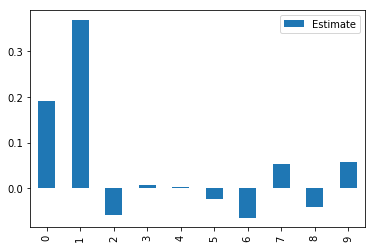

In [37]:
shap.plot.bar();